# Uploading Training Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
path = 'data'
dataset_path = os.listdir( path)

label_types = os.listdir( path)
print (label_types)

['body-building', 'boxing', 'calesthenics', 'cycling', 'swimming', 'yoga']


In [3]:
rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir( path + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str( path + '/' +item) + '/' + room))

# Build a dataframe
data = pd.DataFrame( data=rooms, columns=['tag', 'video_name'])
print(data.head())
print(data.tail())

             tag                 video_name
0  body-building   data/body-building/1.mp4
1  body-building  data/body-building/10.mp4
2  body-building  data/body-building/11.mp4
3  body-building  data/body-building/12.mp4
4  body-building  data/body-building/13.mp4
       tag                                         video_name
1633  yoga  data/yoga/Young Healthy Girl Practicing Yoga B...
1634  yoga  data/yoga/Young Pregnant Woman Doing Yoga Outd...
1635  yoga  data/yoga/Young Woman Doing Balance Exercise S...
1636  yoga  data/yoga/Young Woman Doing Meditation Exercis...
1637  yoga  data/yoga/Young Woman Doing Yoga White Room St...


In [4]:
df = data.loc[:,['video_name','tag']]
df
df.to_csv('fitness_data.csv')

# Preparing Test Data

In [5]:
df = df.sample(frac = 1)

from sklearn.model_selection import train_test_split

train_data, test_data= train_test_split( data, test_size=0.2, random_state=42)

<Axes: xlabel='tag', ylabel='count'>

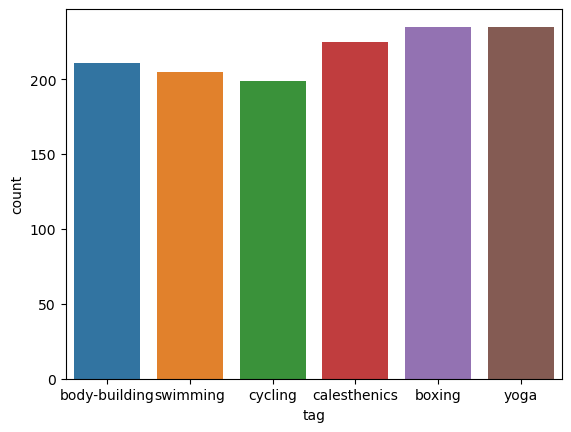

In [6]:
import seaborn as sns

sns.countplot(x=train_data['tag'])


<Axes: xlabel='tag', ylabel='count'>

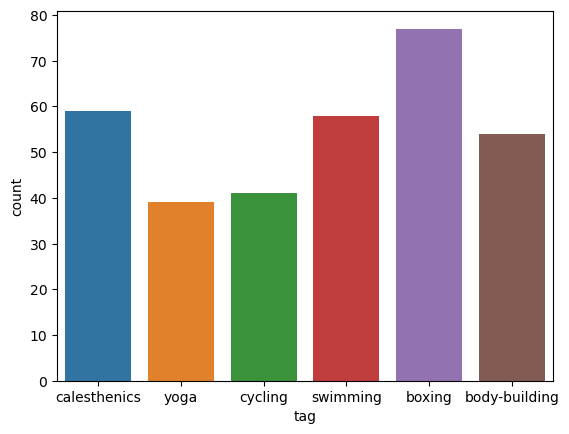

In [7]:
sns.countplot(x=test_data['tag'])

In [8]:
#!pip install git+https://github.com/tensorflow/docs

In [9]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

# Data preparation

In [11]:
print(f"Total videos for training: {len( train_data)}")
print(f"Total videos for testing: {len(test_data)}")


train_data.sample(10)

Total videos for training: 1310
Total videos for testing: 328


,tag,video_name
1598,yoga,"data/yoga/Yoga Video Footage – Browse 197,616 ..."
448,boxing,"data/boxing/Shadow boxing stock photos, royalt..."
224,body-building,"data/body-building/Leg press stock photos, roy..."
188,body-building,"data/body-building/Lateral raise stock photos,..."
110,body-building,data/body-building/Cable flies exercise stock ...
52,body-building,data/body-building/58.mp4
355,boxing,"data/boxing/Punching bag boxing stock photos, ..."
1522,yoga,"data/yoga/Yoga stock photos, royalty-free imag..."
1004,cycling,data/cycling/Cycling Video Footage – Browse 57...
849,calesthenics,"data/calesthenics/Squats stock photos, royalty..."


# Preprocessing Data


In [12]:
IMG_SIZE = 360

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

* Feature Extraction

In [13]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

* Label Encoding

In [14]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique( train_data[ 'tag']))
print( label_processor.get_vocabulary())

labels = train_data[ 'tag'].values
labels = label_processor( labels[..., None]).numpy()
labels

['body-building', 'boxing', 'calesthenics', 'cycling', 'swimming', 'yoga']



array([[0],
       [4],
       [3],
       ...,
       [2],
       [5],
       [4]], dtype=int64)

In [15]:
IMG_SIZE = 360
BATCH_SIZE = 64
EPOCHS = 100

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [16]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()

    ##take all classlabels from train_df column named 'tag' and store in labels
    labels = df["tag"].values

    #convert classlabels to label encoding
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool") # 145,20
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32") #145,20,2048

    # For each video.
    for idx, path in enumerate(video_paths):
        print( idx)
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos( train_data, path)
test_data, test_labels = prepare_all_videos( test_data, path)

print(f"Frame features in train set: {data[0].shape}")
print(f"Frame masks in train set: {data[1].shape}")



print(f"train_labels in train set: {train_labels.shape}")

print(f"test_labels in train set: {test_labels.shape}")

# MAX_SEQ_LENGTH = 20, NUM_FEATURES = 2048. We have defined this above under hyper parameters

KeyError: 0

# The sequence model
Now, we can feed this data to a sequence model consisting of recurrent layers like GRU.

In [17]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.LSTM(16, return_sequences=True, stateful=False)(frame_features_input, mask=mask_input)
    x = keras.layers.LSTM(8, stateful=False)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "./tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()


Epoch 1/100

28/29 [===========================>..] - ETA: 0s - loss: 1.7919 - accuracy: 0.1518
Epoch 1: val_loss improved from inf to 1.79165, saving model to ./tmp\video_classifier
29/29 [==============================] - 12s 124ms/step - loss: 1.7919 - accuracy: 0.1507 - val_loss: 1.7917 - val_accuracy: 0.1726
Epoch 2/100
29/29 [==============================] - ETA: 0s - loss: 1.7916 - accuracy: 0.1845
Epoch 2: val_loss improved from 1.79165 to 1.79149, saving model to ./tmp\video_classifier
29/29 [==============================] - 0s 12ms/step - loss: 1.7916 - accuracy: 0.1845 - val_loss: 1.7915 - val_accuracy: 0.1675
Epoch 3/100
27/29 [==========================>...] - ETA: 0s - loss: 1.7914 - accuracy: 0.1852
Epoch 3: val_loss improved from 1.79149 to 1.79147, saving model to ./tmp\video_classifier
29/29 [==============================] - 0s 12ms/step - loss: 1.7914 - accuracy: 0.1845 - val_loss: 1.7915 - val_accuracy: 0.1675
Epoch 4/100
29/29 [==============================] -

# Inference

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path_):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join( path, path_))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

test_video = np.random.choice( test_data["video_name"].values.tolist())
print(f"Test video path: {test_video}")

test_frames = sequence_prediction(test_video)


In [ ]:
from IPython.display import HTML

HTML("""
    <video alt="test" width="520" height="440" controls>
        <source src="" type="video/mp4" style="height:300px;width:300px">
    </video>
""")
